<font size=6><B>Task 3</B></font>
<br>
<br>
<font size=4><B>邹少锋 2019311000</B></font>

添加了复活机制，使得赌博这个马尔可夫链中的每个状态不仅仅由玩家手中的硬币数决定，还由玩家是否具有复活机会决定。

换个角度可认为每个玩家拥有生命值，设三个玩家大熊、胖虎、静香分别初始时拥有两条命，三人手中的硬币总数为15。

In [1]:
import numpy as np
from random import choice
import pandas as pd
import random
import argparse
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D drawing in space
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams.update({'font.size': 22})
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

parser = argparse.ArgumentParser(description='manual to this script')
parser.add_argument('-a', '--money-a', type=int, default = 5, help="Money of player 大熊")
parser.add_argument('-b', '--money-b', type=int, default = 5, help="Money of player 胖虎")
parser.add_argument('-c', '--money-c', type=int, default = 5, help="Money of player 静香")
parser.add_argument('-hp', '--hp', type=int, default = 2, help="Lives of each player at start")
parser.add_argument('-ts', '--total_simulation', type=int, default=3000, help="Simulation times")
 
args = parser.parse_args([])
print(args)

money_a = args.money_a
money_b = args.money_b
money_c = args.money_c
hp_a = args.hp
hp_b = args.hp
hp_c = args.hp
HP = args.hp
N = money_a + money_b + money_c # total money
total_simulation = args.total_simulation

Namespace(hp=2, money_a=5, money_b=5, money_c=5, total_simulation=3000)


In [2]:
'''Some utils'''   
# Change matplotlib front size setting
plt.rcParams.update({'font.size': 15})
# save numpy array to csv file
def save_matrix(a, name = 'information_of_R_matrix.csv'):
    df = pd.DataFrame(a)
    df.to_csv(name, index=False, encoding='utf_8_sig') 

# Section I. 枚举非常返态和吸收态

例如当前大熊、胖虎、静香手里的硬币数为（1，2，12），三人的生命值都为（2，2，2）。

经过一次赌博后，大熊输，静香赢，则三者手中的硬币数为（0，2，13），三人的生命值为（2，2，2）。

由于大熊还有机会复活，回到上局状态后大熊失去一条命。则三者手中的硬币数变为（1，2，12），三人的生命值变为（1，2，2）。

又经过一轮赌博后，大熊又输了，胖虎赢，由于大熊只有最后一条命，所以认为大熊出局，游戏结束。此时三者手中的硬币数变为（0，3，12），三人的生命值变为（1，2，2）。

由此可知非常返态（游戏可以继续）中，三者的硬币数都不为零，且生命值都大于等于1。吸收态（游戏结束）中，三者只有一个人的硬币数为零，且这个人的生命值等于1。

某位玩家如大熊只有1枚硬币，且生命值大于1时，如上述中的某个状态三人的硬币数为（1，2，12），生命值为（2，2，2），记为状态（1，2，12，2，2，2）。

如果在某次博弈中，大熊输给了静香，则根据规则状态大熊丢失一个生命，经历了状态 A（1，2，12，2，2，2）-> B（0，2，13，2，2，2）-> C（1，2，12，1，2，2）

为了满足Markov链的性质，即下一状态只取决于上一状态和博弈过程。

但从B状态到C状态过程中不存在博弈只有复活（重返游戏）的过程，复活时B还可以进入其他状态如D（1，1，13，1，2，2）。

故为使其仍满足Markov链性质，下面略去状态B，从状态A且博弈中大熊只要输了后进入直接进入状态C，即A（1，2，12，2，2，2）-> C（1，2，12，1，2，2）。

### i. 枚举非常返态

设初始状态，三人的生命值都为HP，三人的硬币总数为N，则可推导出非常返态的总状态数为 p = (N-1) * (N-2) * HP^3

In [3]:
non_recurrent_states = [] # each player have more than one corn
p = int((N-1)*(N-2)/2*args.hp*args.hp*args.hp) # total numbers of non recurrent states
for i in range(1, N-2+1):
    for j in range(1, N-i-1+1):
        coin_a = i
        coin_b = j
        coin_c = N-i-j
        for hp_a in range(1, args.hp + 1):
            for hp_b in range(1, args.hp + 1):
                for hp_c in range(1, args.hp + 1):
                    non_recurrent_states.append((coin_a, coin_b, coin_c, hp_a, hp_b, hp_c))
assert len(non_recurrent_states) == p, 'Non recurrent state has wrong calculation, the calculated number of states are %d but p is %d'%(len(non_recurrent_states), p)
print('The numbers of non recurrent states are %d'%p)

valid_start_state_idx = []
for idx, state in enumerate(non_recurrent_states):
    if state[3] == args.hp and state[4] == args.hp and state[5] == args.hp: # The initial state should be the same as all lives
        valid_start_state_idx.append(idx)
valid_start_states = np.array(non_recurrent_states)[valid_start_state_idx].tolist()
valid_p = len(valid_start_states)
print('The numbers of start non recurrent states are %d'%valid_p)

The numbers of non recurrent states are 728
The numbers of start non recurrent states are 91


In [4]:
print('Some non recurrent states:', non_recurrent_states[:10])

Some non recurrent states: [(1, 1, 13, 1, 1, 1), (1, 1, 13, 1, 1, 2), (1, 1, 13, 1, 2, 1), (1, 1, 13, 1, 2, 2), (1, 1, 13, 2, 1, 1), (1, 1, 13, 2, 1, 2), (1, 1, 13, 2, 2, 1), (1, 1, 13, 2, 2, 2), (1, 2, 12, 1, 1, 1), (1, 2, 12, 1, 1, 2)]


### ii. 枚举吸收态

设初始状态，三人的生命值都为HP，三人的硬币总数为N，则可推导出吸收态的总状态数为 q = 3 * (N-1) * HP\^2

In [5]:
absorbing_states = [] # one player has zero corn and the hp is one.
q = int(3*(N-1)*args.hp**2) # total numbers of absorbing states
for i in range(1, N-1+1):     
    coin_a, coin_b, coin_c = 0,i,N-i
    for hp_b in range(1, args.hp + 1):
        for hp_c in range(1, args.hp + 1):
            absorbing_states.append((coin_a, coin_b, coin_c, 1, hp_b, hp_c))
for i in range(1, N-1+1):     
    coin_a, coin_b, coin_c = i,0,N-i
    for hp_a in range(1, args.hp + 1):
        for hp_c in range(1, args.hp + 1):
            absorbing_states.append((coin_a, coin_b, coin_c, hp_a, 1, hp_c))
for i in range(1, N-1+1):     
    coin_a, coin_b, coin_c = i,N-i,0
    for hp_a in range(1, args.hp + 1):
        for hp_b in range(1, args.hp + 1):
            absorbing_states.append((coin_a, coin_b, coin_c, hp_a, hp_b, 1))
assert len(absorbing_states) == q, 'Absorbing state has wrong calculation, the calculated number of states are %d but p is %d'%(len(non_recurrent_states), p)
print('The numbers of absorbing state are %d'%q)
# Merge the absorbing state according to the distribution of coins
valid_absorbing_states,indices = np.unique(np.array(absorbing_states)[:,:3], axis=0, return_index=True)
valid_absorbing_states = np.array(absorbing_states)[:,:3][sorted(indices),:]
valid_q = valid_absorbing_states.shape[0]
print('The numbers of valid absorbing state according to the distribution of coins are %d'%valid_q)

The numbers of absorbing state are 168
The numbers of valid absorbing state according to the distribution of coins are 42


In [6]:
print('Some absorbing states:', absorbing_states[:10])

Some absorbing states: [(0, 1, 14, 1, 1, 1), (0, 1, 14, 1, 1, 2), (0, 1, 14, 1, 2, 1), (0, 1, 14, 1, 2, 2), (0, 2, 13, 1, 1, 1), (0, 2, 13, 1, 1, 2), (0, 2, 13, 1, 2, 1), (0, 2, 13, 1, 2, 2), (0, 3, 12, 1, 1, 1), (0, 3, 12, 1, 1, 2)]


# Section II. 计算从非常返态到吸收态的转移时间

### i.构造D矩阵

某个非常返态到另一个非常返态的转移概率计算：
1. 如果所有玩家生命值都未降低，则存在转移概率的非常返态之间需满足：

    * 某个玩家前后状态的硬币数降低1，另一个玩家的前后状态的硬币数升高1
    
    * 该转移概率为1/6
    
    
2. 如果有玩家生命值降低，则存在转移概率的非常返态之间需满足：

    * 该玩家之前的状态的硬币数为1，前后状态除了该玩家的生命值有降低，其他都未变化
    
    * 该转移概率为1/3，因为该玩家输的话有两种可能性，比如大熊输了，那他可能输给了胖虎，也可能是静香

In [7]:
def judge_neighbor_nonrec2nonrec_state(state_a, state_b):
    c = np.array(state_a)-np.array(state_b)
    d = np.abs(c)
    if c[3]==0 and c[4]==0 and c[5]==0:# condition1
        if np.sum(c)==0 and np.sum(d)==2 and c[0]*c[1]*c[2]==0: #condition1
            return 1/6
        else:
            return 0
    elif np.sum(c[3:])==1 and np.sum(d[3:])==1 and c[3]*c[4]*c[5]==0 and np.array(state_a)[np.where(c[3:]==1)]==1 and c[0] == 0 and c[1] == 0 and c[2] == 0:# condition2
        return 1/3 
    else:
        return 0

In [8]:
D = np.zeros((p,p))
for idx1, state_a in enumerate(non_recurrent_states):
    for idx2, state_b in enumerate(non_recurrent_states):
        neighbor_res = judge_neighbor_nonrec2nonrec_state(state_a, state_b)
        D[idx1][idx2] = neighbor_res

In [9]:
save_matrix(D, 'information_of_D_matrix.csv')

### ii. 理论计算游戏结束时赌博的平均次数

In [10]:
I = np.eye(p)
g = np.ones((p,1))
w = np.dot(np.linalg.inv(I - D), g).squeeze()
valid_start_w = np.array(w)[valid_start_state_idx]    

In [11]:
valid_start_w[:5]

array([ 7.83365206, 11.74145578, 14.8988201 , 17.33571726, 19.06863454])

### iii. 仿真模拟游戏结束时赌博的平均次数


In [12]:
def simulation(money_a, money_b, money_c, hp, total_simulation):
    hp_a = hp
    hp_b = hp
    hp_c = hp
    results = np.zeros((total_simulation, 7))
    print_interval = 1000
    for cur_simulation in range(total_simulation):
        player = {'a':money_a, 'b':money_b, 'c':money_c}
        lives = {'a':hp, 'b':hp, 'c':hp}
        iteration = 0
        game_over_flag = False
        while(game_over_flag == False):
            '''iteration information'''
            iteration += 1
            
            '''choose two player randomly''' 
            total_player = list(player.keys())
            player_m = choice(total_player)
            total_player.remove(player_m) 
            player_n = choice(total_player)

            '''exchange coin'''
            player[player_m] = player[player_m] - 1
            player[player_n] = player[player_n] + 1    

            '''judge whether to keep on gaming'''
            if player[player_m] == 0:
                if lives[player_m] != 1:
                    # lives minus 1
                    lives[player_m] -= 1
                    # back to previous status
                    player[player_m] = player[player_m] + 1
                    player[player_n] = player[player_n] - 1  
                else:
                    game_over_flag = True                        

            '''save the final state'''
            if game_over_flag == True:
                results[cur_simulation, :6] = tuple(player.values()) + tuple(lives.values())
                results[cur_simulation, 6] = iteration
                if cur_simulation % print_interval == 0:
                    print('Simulation: %d, Result:'%cur_simulation, results[cur_simulation, :], end = '\r')
    
    return results

In [13]:
simulation_times = []
# for every initial state(distribution of coins at start of game)
for idx, state in enumerate(valid_start_states): 
    res = simulation(state[0], state[1], state[2], args.hp, total_simulation)
    # calculate mean of simulation times
    simulation_time = np.mean(res[:,6])
    simulation_times.append(simulation_time)
simulation_times = np.array(simulation_times)

### iv. 数据分析

#### a. 理论计算与仿真模拟的平均绝对误差

In [14]:
# calculate the mean of absolute error
np.mean(np.abs(valid_start_w-simulation_times))

0.31570443345716376

#### b. 理论计算与仿真模拟对比

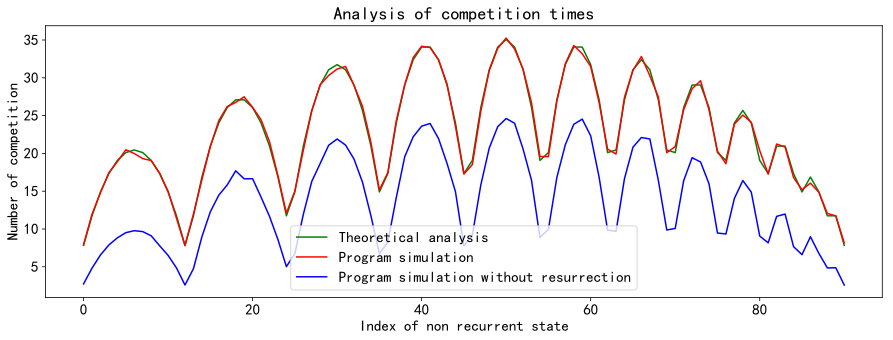

In [16]:
task2_simulation_times = np.load( 'log/task2_simulation_times.npy')
plt.figure(figsize=(15,5), dpi = 144)
plt.title('Analysis of competition times')
plt.plot(list(range(valid_start_w.shape[0])), valid_start_w, color='green', label='Theoretical analysis')
plt.plot(list(range(valid_start_w.shape[0])), simulation_times, color='red', label='Program simulation')
plt.plot(list(range(valid_start_w.shape[0])), task2_simulation_times, color='blue', label='Program simulation without resurrection')
plt.legend() # Show legend
plt.xlabel('Index of non recurrent state')
plt.ylabel('Number of competition')
plt.savefig('figure/Task3-Number of competition 2D view with HP=%d.svg'%HP)
plt.savefig('figure/Task3-Number of competition 2D view with HP=%d.png'%HP)
plt.show() 

上图中横坐标是所有的初始的非常返态，纵坐标是从对应的非常返态到吸收态（从游戏开始到游戏结束）所对弈的平均次数。
可以看出添加了复活机制后，平均对弈次数有所提升。



#### c. 游戏结束时赌博的平均次数与初始硬币数分布关系

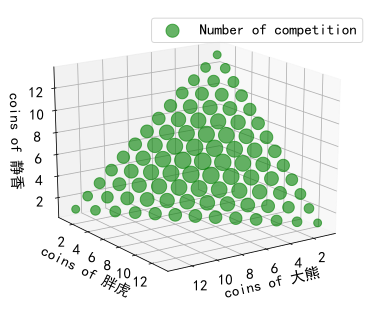

In [17]:
# Scatter plot
fig = plt.figure(figsize=(5,4), dpi=144)
ax = Axes3D(fig)
elev = 20.0
azim = 55.5
ax.view_init(elev, azim)
ax.scatter(np.array(valid_start_states)[:,0], np.array(valid_start_states)[:,1], np.array(valid_start_states)[:,2], s=valid_start_w[:]*8, c='g', marker='o', label='Number of competition', alpha=0.6)
ax.set_xlabel('coins of 大熊', fontsize=15)
ax.set_ylabel('coins of 胖虎', fontsize=15)
ax.set_zlabel('coins of 静香', fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figure/Task3-Number of competition 3D view with HP=%d.svg'%HP)
plt.savefig('figure/Task3-Number of competition 3D view with HP=%d.png'%HP)
plt.show()

上图中，不同得绿色圆圈代表了不同得起始状态（初始得三个玩家得硬币分布）博弈至游戏结束所需要得平均博弈次数，绿色圆圈越大表示平均博弈次数也越大。

从中可以发现，当三名玩家得硬币分布越接近，所需要得博弈次数也越多。相比于没有复活机制，所需的对弈次数也更多。

# Section III. 计算从非常返态到吸收态的转移概率

### i. 构造R矩阵

非常返态到吸收态的转移概率计算：
1. 三名玩家的生命值都未有变化。
1. 三名玩家中，有个玩家的硬币数降低1，另一个玩家的硬币数增加1。
2. 硬币数变为0的玩家，前一状态的生命值为1。

符合上述条件的非常返态和吸收态之间的转移概率为1/6。 

In [18]:
def judge_neighbor_nonrec2absorb_state(state_a, state_b):
    c = np.array(state_a)-np.array(state_b)
    d = np.abs(c)
    if c[3]==0 and c[4]==0 and c[5]==0: # condition1
        if np.sum(c)==0 and np.sum(d)==2 and c[0]*c[1]*c[2]==0: # condition2
            if np.array(state_a)[3:][np.where(c[0:3]==1)]==1: #condition3
                return 1/6
    return 0

In [19]:
R = np.zeros((p,q))
for idx1, state_a in enumerate(non_recurrent_states):
    for idx2, state_b in enumerate(absorbing_states):
        neighbor_res = judge_neighbor_nonrec2absorb_state(state_a, state_b)
        R[idx1][idx2] = neighbor_res

In [20]:
save_matrix(R, 'log/Task3-information_of_R_matrix.csv')

### ii. 理论计算游戏结束时硬币数的分布

非常返态包括了已丢失部分生命的状态，我们只需要全为满血的初始非常返态到吸收态的概率

吸收态中又包含了生命值部分，而我们关注的是硬币数分布，所以根据硬币数分布再对具有相同硬币数分布的吸收态进行合并

In [21]:
I = np.eye(p)
U = np.dot(np.linalg.inv(I - D), R)
# Choose valid state according to initial non recurrent state
valid_U = np.array(U)[valid_start_state_idx] 
# Merge the state according to the distribution of coins
temp_valid_U = np.zeros((valid_U.shape[0], valid_absorbing_states.shape[0]))
for idx, state in enumerate(valid_absorbing_states):
    target_idx = np.where(np.sum(np.array(absorbing_states)[:,:3]==state, axis=1)==3)[0]
    target_idx = np.array(target_idx)
    temp_valid_U[:,idx] = np.sum(valid_U[:, target_idx], axis=1)
valid_U = temp_valid_U
valid_U.shape

(91, 42)

In [22]:
save_matrix(U, 'log/Task3-information_of_U_matrix.csv')

### iii. 仿真模拟游戏结束时硬币数的分布

In [23]:
simulation_probabilitys = []
total_res = []
# For every initial state(distribution of coins at start of game)
for idx, state in enumerate(valid_start_states):
    res = simulation(state[0], state[1], state[2], args.hp, total_simulation)
    total_res.append(res)
    res_absorbing_state_index = [absorbing_states.index(tuple(ele[:6])) for ele in res]
    hist, bin_edges = np.histogram(res_absorbing_state_index, bins=list(range(0,len(absorbing_states)+1)), density=True)
    simulation_probabilitys.append(hist)
simulation_probabilitys = np.array(simulation_probabilitys)

# Merge the simulation probabilitys accroding to the distribution of coins
temp_valid_simulation_probabilitys = np.zeros((simulation_probabilitys.shape[0], valid_absorbing_states.shape[0]))
for idx, state in enumerate(valid_absorbing_states):
    target_idx = np.where(np.sum(np.array(absorbing_states)[:,:3]==state, axis=1)==3)[0]
    target_idx = np.array(target_idx)
    temp_valid_simulation_probabilitys[:,idx] = np.sum(simulation_probabilitys[:, target_idx], axis=1)
simulation_probabilitys = temp_valid_simulation_probabilitys 

### iv. 数据分析

#### a. 理论计算与仿真模拟的平均绝对误差

In [24]:
# calculate the mean of absolute error
np.mean(np.abs(valid_U-simulation_probabilitys))

0.001828755315346418

#### b. 理论计算与仿真模拟对比

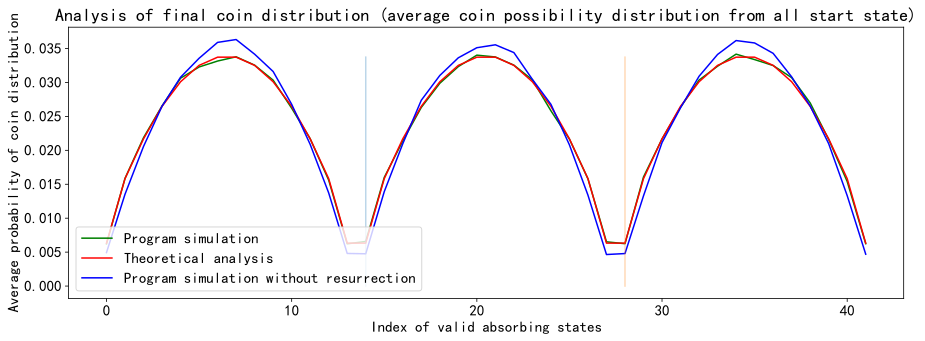

In [32]:
task2_simulation_probabilitys = np.load('log/task2_simulation_probabilitys.npy')

plt.figure(figsize=(20,5), dpi = 144)
plt.title('Analysis of final coin distribution (average coin possibility distribution from all start state)')

plt.plot(list(range(valid_q)), np.mean(simulation_probabilitys, axis=0), color='green', label='Program simulation')
plt.plot(list(range(valid_q)), np.mean(valid_U, axis=0), color='red', label='Theoretical analysis')
plt.plot(list(range(valid_q)), np.mean(task2_simulation_probabilitys, axis=0), color='blue', label='Program simulation without resurrection')

points = [ (valid_q/3,np.max(np.mean(valid_U, axis=0))), (valid_q*2/3,np.max(np.mean(valid_U, axis=0))) ] # (a1,b1), (a2,b2), ...
for pt in points:
    plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)
    
plt.legend()
plt.xlabel('Index of valid absorbing states')
plt.ylabel('Average probability of coin distribution')
plt.savefig('figure/Task3-Average probability of coin distribution 2D view with HP=%d.svg'%HP)
plt.savefig('figure/Task3-Average probability of coin distribution 2D view with HP=%d.png'%HP)
plt.show() 

上图中横坐标是所有的游戏结束时的硬币分布，纵坐标是从对应的从所有非常返态到该硬币分布的平均概率。

和没有复活机制的结果相比，增加复活机制之后，游戏结束时的硬币分布稍微均匀一些。

#### c. 从初始硬币数为(5,5,5)到游戏结束时每种硬币数分布的概率

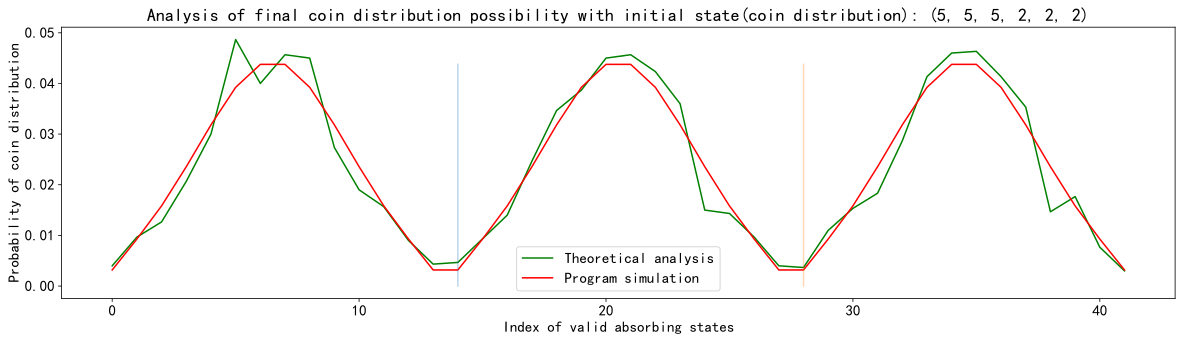

In [33]:
# The initial state is when all three have 5 coins
state_index = non_recurrent_states.index((money_a, money_b, money_c, args.hp, args.hp, args.hp))
index = valid_start_state_idx.index(state_index)

plt.figure(figsize=(20,5), dpi = 144)
plt.title('Analysis of final coin distribution possibility with initial state(coin distribution): %s'%str(non_recurrent_states[state_index]))
plt.plot(list(range(valid_q)), simulation_probabilitys[index], color='green', label='Theoretical analysis')
plt.plot(list(range(valid_q)), valid_U[index], color='red', label='Program simulation')

points = [ (valid_q/3,np.max(valid_U[index])), (valid_q*2/3,np.max(valid_U[index])) ] # (a1,b1), (a2,b2), ...
for pt in points:
    plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)

plt.legend() # show legend

plt.xlabel('Index of valid absorbing states')
plt.ylabel('Probability of coin distribution')
plt.savefig('figure/Task3-Probability of coin distribution 2D view with HP=%d.svg'%HP)
plt.savefig('figure/Task3-Probability of coin distribution 2D view with HP=%d.png'%HP)
plt.show() 

#### d. 从初始硬币数为(5,5,5)到游戏结束时每种硬币数分布

Suppose the names of three players are "大熊", "胖虎" and "静香"


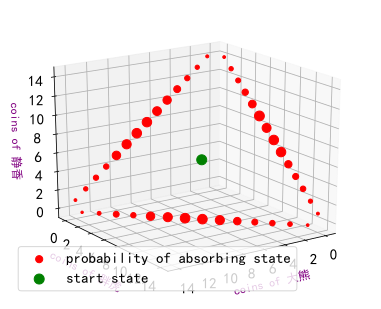

In [27]:
player = {'a':money_a, 'b':money_b, 'c':money_c}
print('Suppose the names of three players are "大熊", "胖虎" and "静香"')
player_name = list(["大熊", "胖虎" , "静香"])

state_index = non_recurrent_states.index((money_a, money_b, money_c, args.hp, args.hp, args.hp))
index = valid_start_state_idx.index(state_index)

fig = plt.figure(figsize=(5,4), dpi=144)
ax = Axes3D(fig)
elev = 20.0
azim = 55.5
ax.view_init(elev, azim)
 
ax.scatter(valid_absorbing_states[:,0], valid_absorbing_states[:,1], valid_absorbing_states[:,2], c = 'r', s = simulation_probabilitys[index]*2000, alpha = 1, label = 'probability of absorbing state')
ax.scatter(non_recurrent_states[state_index][0], non_recurrent_states[state_index][1], non_recurrent_states[state_index][2], c = 'g', s = 100, alpha = 1, label = 'start state')
ax.set_xlabel('coins of 大熊', fontdict={'size': 12, 'color': 'purple'})
ax.set_ylabel('coins of 胖虎', fontdict={'size': 12, 'color': 'purple'})
ax.set_zlabel('coins of 静香', fontdict={'size': 12, 'color': 'purple'})
plt.legend()
plt.savefig('figure/Task3-Probability of coin distribution 3D view with HP=%d.svg'%HP)
plt.savefig('figure/Task3-Probability of coin distribution 3D view with HP=%d.png'%HP)
plt.show()

上图中，绿色的圆圈表示初始状态（初始得三个玩家的硬币数为(5,5,5)）的位置。

不同的红色圆圈代表了从起始状态博弈至游戏结束的硬币分布概率，红色圆圈越大表示最终为该硬币分布的概率越大。

从中可以发现，当三名玩家得硬币分布接近一致时，最终的硬币分布也是对称的，且另外两个仍有硬币的玩家的硬币数也是大概率是一样的，和我们的认知常识保持一致。

#### e. 任选几个初始硬币数分布到游戏结束时的硬币数概率分布

Suppose the names of three players are "大熊", "胖虎" and "静香"


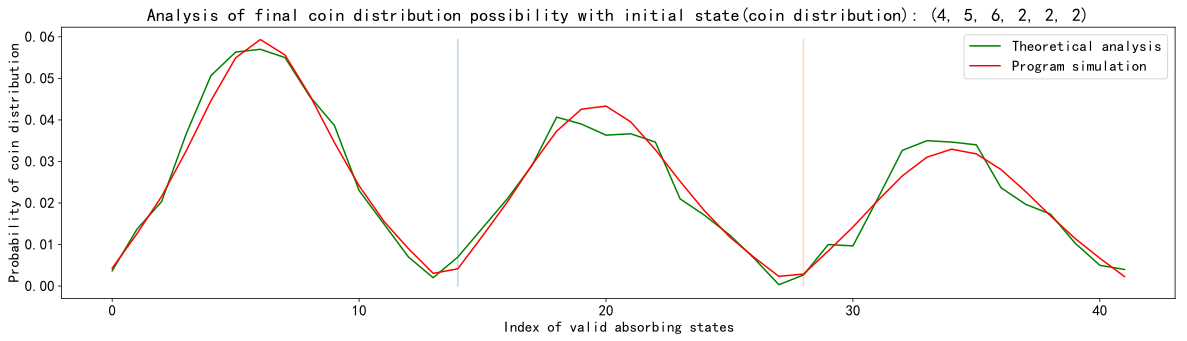

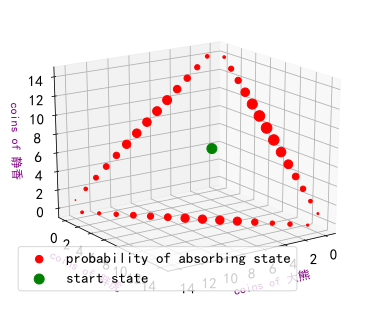

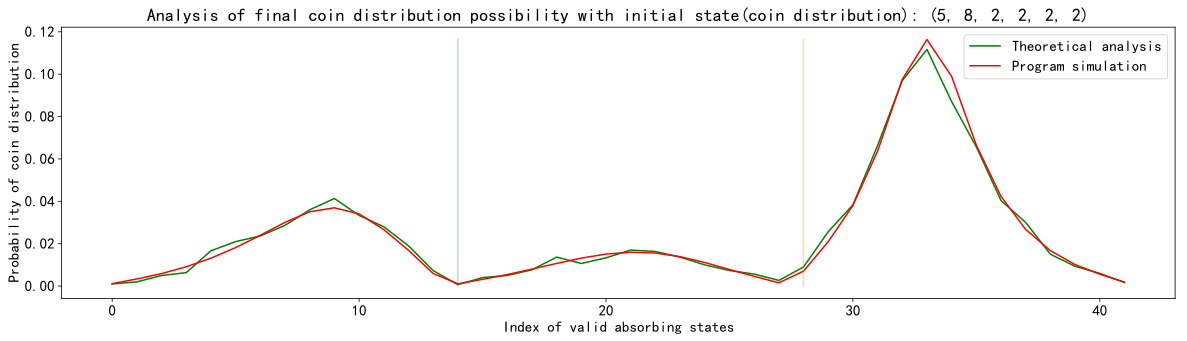

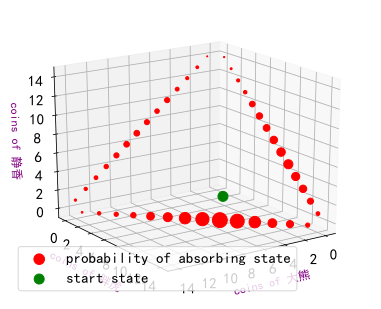

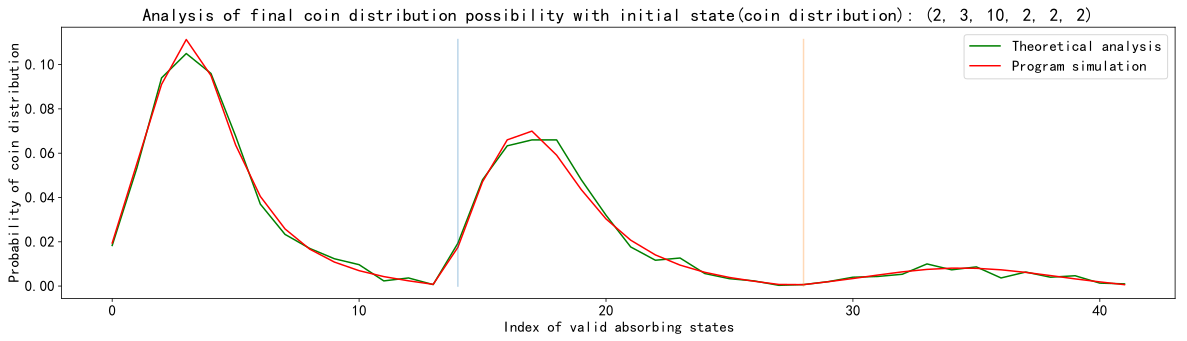

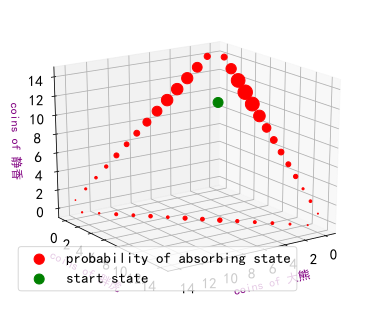

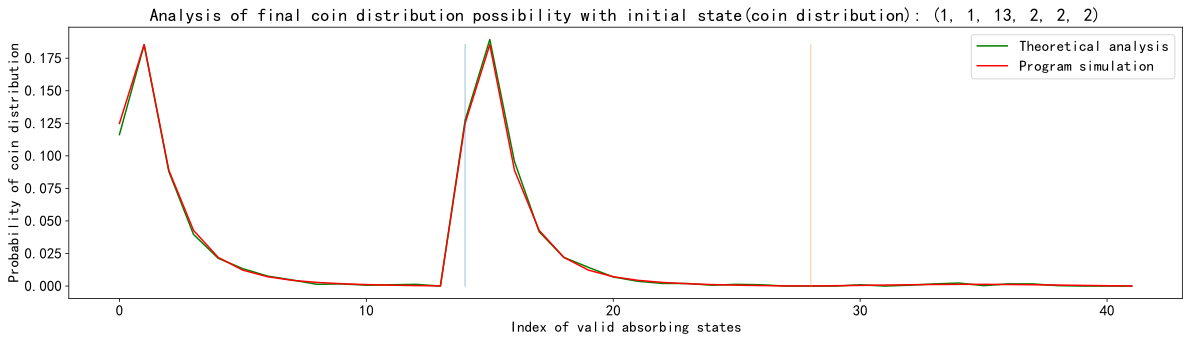

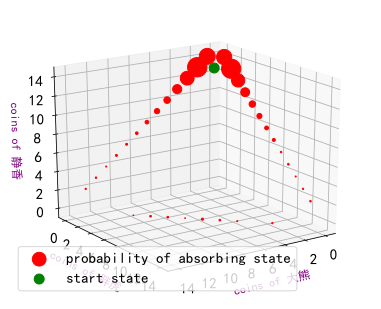

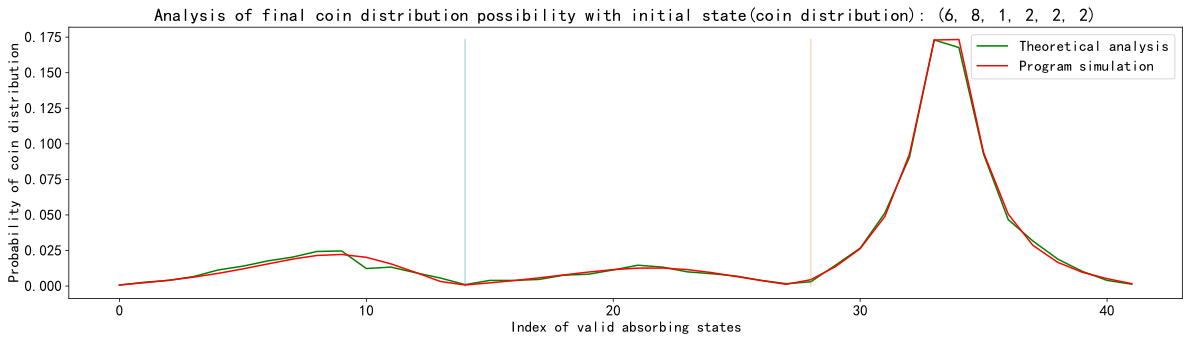

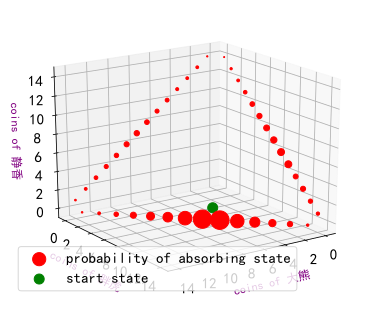

In [34]:
player = {'a':money_a, 'b':money_b, 'c':money_c}
print('Suppose the names of three players are "大熊", "胖虎" and "静香"')
player_name = list(["大熊", "胖虎" , "静香"])

# Randomly select several initial states and observe the final distribution
import random 
random_selected_index = random.choices(valid_start_state_idx, k=5)
for state_index in random_selected_index:
    index = valid_start_state_idx.index(state_index)
    '''2D view'''
    plt.figure(figsize=(20,5), dpi = 144)
    plt.title('Analysis of final coin distribution possibility with initial state(coin distribution): %s'%str(non_recurrent_states[state_index]))
    plt.plot(list(range(valid_q)), simulation_probabilitys[index], color='green', label='Theoretical analysis')
    plt.plot(list(range(valid_q)), valid_U[index], color='red', label='Program simulation')

    points = [ (valid_q/3,np.max(valid_U[index])), (valid_q*2/3,np.max(valid_U[index])) ] # (a1,b1), (a2,b2), ...
    for pt in points:
        plt.plot( [pt[0],pt[0]], [0,pt[1]], alpha=0.3)

    plt.legend() # show legend

    plt.xlabel('Index of valid absorbing states')
    plt.ylabel('Probability of coin distribution')
    plt.show() 
    
    '''3D view'''
    fig = plt.figure(figsize=(5,4), dpi=144)
    ax = Axes3D(fig)
    elev = 20.0
    azim = 55.5
    ax.view_init(elev, azim)

    ax.scatter(valid_absorbing_states[:,0], valid_absorbing_states[:,1], valid_absorbing_states[:,2], c = 'r', s = simulation_probabilitys[index]*2000, alpha = 1, label = 'probability of absorbing state')
    ax.scatter(non_recurrent_states[state_index][0], non_recurrent_states[state_index][1], non_recurrent_states[state_index][2], c = 'g', s = 100, alpha = 1, label = 'start state')
    ax.set_xlabel('coins of 大熊', fontdict={'size': 12, 'color': 'purple'})
    ax.set_ylabel('coins of 胖虎', fontdict={'size': 12, 'color': 'purple'})
    ax.set_zlabel('coins of 静香', fontdict={'size': 12, 'color': 'purple'})
    plt.legend()
    plt.show()